Họ tên: Võ Thành Nam

STT: 10

# Một cách tiếp cận sử dụng LSTM

## 1. Đọc dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

import torch
import torch.nn as nn 
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\Nam\miniconda3\envs\torch-coding\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Chuyển nhãn `Positive` thành `1` và `Negative` thành `0`.

In [2]:
df = pd.read_csv('VDT2023_MR_train.csv')
df.replace(to_replace={'Positive':1, 'Negative':0}, inplace=True)
df

,Review,Sentiment
0,"in tim burton's `sleepy hollow' , there is a m...",1
1,i read the new yorker magazine and i enjoy som...,0
2,""" jack frost , "" is one of those dumb , corny...",0
3,""" some houses are born bad , "" goes the haunt...",0
4,director david fincher has such an eye for det...,1
...,...,...
1595,""" the fighting sullivans "" contains a major p...",1
1596,"once again , the battle is dreamworks versus d...",1
1597,"by the time dennis quaid , the ostensible star...",0
1598,from dusk till dawn ( director/editor : robert...,0


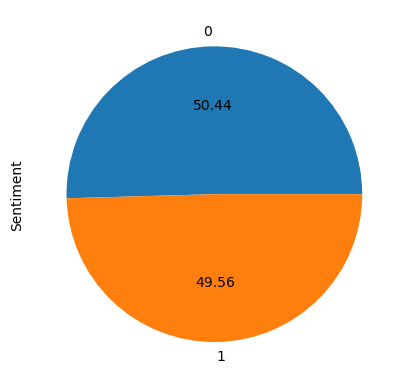

In [3]:
df.Sentiment.value_counts().plot(kind='pie', autopct='%.2f');

## Tiền xử lí

Vì dữ liệu nhỏ nên sẽ không có tập val

In [4]:
X_df = df.drop('Sentiment', axis=1)
y_df = df['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(X_df, 
                                                    y_df, 
                                                    test_size=0.2,
                                                    stratify = y_df, 
                                                    random_state=42)

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer() 
def preprocess(s):
    s = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})', '', s)
    s = re.sub(r'[^\w\s]',' ', s)
    s = re.sub(r'\d', ' ', s)
    s = re.sub(r'\s+', ' ',s)
    s = lemmatizer.lemmatize(s)
    return s

In [6]:
stopwords = stopwords.words('english')

Tokenize các văn bản và padding. Chiều dài tối đa là 1500.

In [7]:
def tokenizer(x_train, y_train, x_val, y_val, stop_words):
    word_list = list()
    for sequence in x_train:
        for word in sequence.lower().split():
            word = preprocess(word)
            if word not in stop_words and word !='':
                word_list.append(word)
    
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train, final_list_test = list(), list()
    for sequence in x_train:
        final_list_train.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                                if preprocess(word) in onehot_dict.keys()])
    for sequence in x_val:
        final_list_test.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                              if preprocess(word) in onehot_dict.keys()])
    return (np.array(final_list_train, dtype='object'), 
            np.array(y_train), 
            np.array(final_list_test, dtype='object'), 
            np.array(y_val), 
            onehot_dict)

In [8]:
x_train, y_train, x_test, y_test, vocab = tokenizer(x_train.Review.to_list(), 
                                             y_train, 
                                             x_test.Review.to_list(), 
                                             y_test, 
                                             stopwords)

In [9]:
print(f'Length of vocab: {len(vocab)}')

Length of vocab: 36305


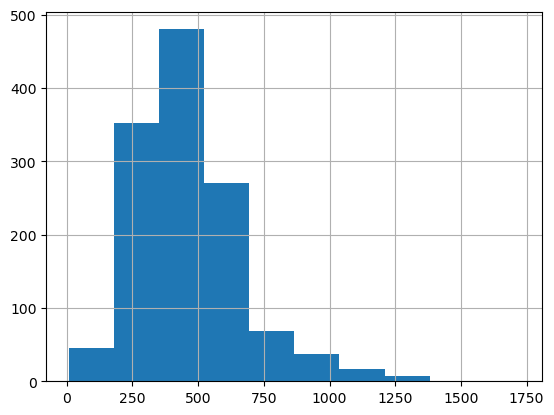

count    1280.000000
mean      463.592969
std       202.719931
min         8.000000
25%       325.750000
50%       435.000000
75%       558.000000
max      1724.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
MAX_LEN = 1500
BATCH_SIZE = 32
n_layers = 1
vocab_size = len(vocab) + 1
output_dims = 1
hidden_dims = 64
embedding_dims = 128

In [12]:
def padding(X, max_len):
    features = np.zeros((len(X), max_len),dtype=int)
    for i, sequence in enumerate(X):
        features[i, -len(sequence):] = np.array(sequence)[:max_len]
    return features
x_train_padding = padding(x_train, MAX_LEN)
x_test_padding = padding(x_test, MAX_LEN)

In [13]:
train_data = TensorDataset(torch.from_numpy(x_train_padding), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_padding), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)

In [14]:
len(test_dataloader.dataset)

320

In [15]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device('cuda')
    print('GPU available')
else:
    device = torch.device('cpu')
    print('CPU available')

GPU available


## Mô hình LSTM bằng PyTorch

In [16]:
class LSTM(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dims, embedding_dims, dropout_rate = 0.5):
        super(LSTM, self).__init__()
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(self.vocab_size, embedding_dims)
        self.lstm = nn.LSTM(input_size = embedding_dims,
                           hidden_size = self.hidden_dims,
                           num_layers = self.n_layers,
                           batch_first = True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.hidden_dims, self.output_dims)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        embedding = self.embedding(x)
        lstm_out, hidden_state = self.lstm(embedding)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dims)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out, hidden_state

In [17]:
model = LSTM(n_layers, vocab_size, hidden_dims, embedding_dims)
model.to(device)

LSTM(
  (embedding): Embedding(36306, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─Embedding: 1-1                         4,647,168
├─LSTM: 1-2                              49,664
├─Dropout: 1-3                           --
├─Linear: 1-4                            65
├─Sigmoid: 1-5                           --
Total params: 4,696,897
Trainable params: 4,696,897
Non-trainable params: 0

In [19]:
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
def accuracy(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [20]:
clip = 5
EPOCHS = 30
valid_loss_min = np.Inf

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}
train_step = len(train_dataloader.dataset) // BATCH_SIZE
test_step = len(test_dataloader.dataset) // BATCH_SIZE

start_time = time.time()
for epoch in range(EPOCHS):
    train_loss = list()
    train_acc = 0
    model.train()
    # hidden_state = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # hidden_state = tuple([each.data for each in hidden_state])
        # print(inputs.shape, hidden_state)
        
        model.zero_grad()
        output, hidden_state = model(inputs)#, hidden_state)
        
        loss = loss_fn(output.squeeze(), labels.float())
        loss.backward()
        
        train_loss.append(loss.item())
        
        acc = accuracy(output, labels)
        train_acc += acc
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # test_h = model.init_hidden(BATCH_SIZE)
    test_loss = list()
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_dataloader:
            # test_h = tuple([each.data for each in test_h])

            inputs, labels = inputs.to(device), labels.to(device)
            output, test_h = model(inputs)

            loss = loss_fn(output.squeeze(), labels.float())
            test_loss.append(loss.item())

            acc = accuracy(output, labels)
            test_acc += acc
    
    epoch_train_loss = np.mean(train_loss)
    epoch_test_loss = np.mean(test_loss)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)#(train_step * BATCH_SIZE)
    epoch_test_acc = test_acc/len(test_dataloader.dataset)#(test_step * BATCH_SIZE)
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['train_acc'].append(epoch_train_acc)
    history['test_acc'].append(epoch_test_acc)
    
    print(f'[INFO] EPOCHS: {epoch + 1}/{EPOCHS}')
    print('Train loss: {:.6f}, Test loss: {:.6f}'.format(epoch_train_loss,epoch_test_loss))
    print('Train acc: {:.4f}, Test acc: {:.4f}\n'.format(epoch_train_acc,epoch_test_acc))    

end_time = time.time()
print('[INFO] total time taken to train the model: {:.2f}s'.format(end_time - start_time))

[INFO] EPOCHS: 1/30
Train loss: 0.700276, Test loss: 0.694225
Train acc: 0.4945, Test acc: 0.5031

[INFO] EPOCHS: 2/30
Train loss: 0.692510, Test loss: 0.693553
Train acc: 0.5141, Test acc: 0.5062

[INFO] EPOCHS: 3/30
Train loss: 0.692985, Test loss: 0.693237
Train acc: 0.5258, Test acc: 0.5062

[INFO] EPOCHS: 4/30
Train loss: 0.691689, Test loss: 0.692884
Train acc: 0.5227, Test acc: 0.5156

[INFO] EPOCHS: 5/30
Train loss: 0.691559, Test loss: 0.692657
Train acc: 0.5328, Test acc: 0.5344

[INFO] EPOCHS: 6/30
Train loss: 0.690411, Test loss: 0.692361
Train acc: 0.5547, Test acc: 0.5281

[INFO] EPOCHS: 7/30
Train loss: 0.690553, Test loss: 0.692094
Train acc: 0.5195, Test acc: 0.5344

[INFO] EPOCHS: 8/30
Train loss: 0.688539, Test loss: 0.691916
Train acc: 0.5305, Test acc: 0.5406

[INFO] EPOCHS: 9/30
Train loss: 0.687588, Test loss: 0.691541
Train acc: 0.5461, Test acc: 0.5188

[INFO] EPOCHS: 10/30
Train loss: 0.685294, Test loss: 0.691320
Train acc: 0.5711, Test acc: 0.5125

[INFO] EP

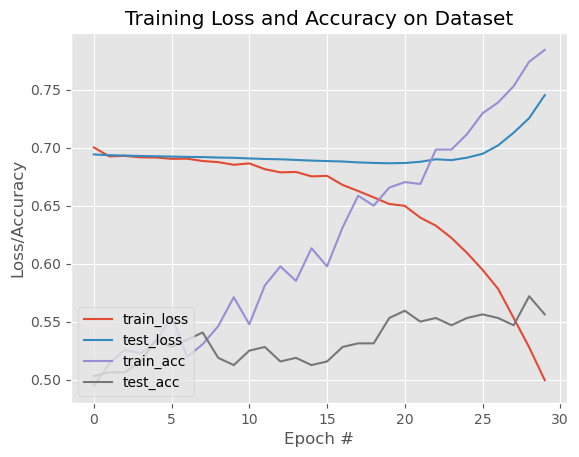

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left");

In [22]:
def evaluate(test_dl, model):
    out = torch.Tensor(())
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            output,_ = model(inputs)
            out = torch.cat((out,output.detach().to('cpu')),dim=0)
    out  = np.round(out)
    print(classification_report(y_test, out))
evaluate(test_dataloader,model)

              precision    recall  f1-score   support

           0       0.58      0.45      0.50       161
           1       0.54      0.67      0.60       159

    accuracy                           0.56       320
   macro avg       0.56      0.56      0.55       320
weighted avg       0.56      0.56      0.55       320



In [23]:
def predict_text(text):
    word_seq = np.array([vocab[preprocess(word)] for word in text.split() 
                                if preprocess(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad = torch.from_numpy(padding(word_seq,500))
    inputs = pad.to(device)
    output, h = model(inputs)
    return(output.item())

In [24]:
i = 0
print('Predict: ',predict_text(df.Review[i]))
print('Actual: ',df.Sentiment[i])

Predict:  0.593357503414154
Actual:  1
